**This script is to read the quadricslam and oa-slam error metrics of all datasets and plot them. Only the dataset_path variable is to be changed which indicates the path to where all dataset is present.**

## Import Modules

In [1]:
import matplotlib.collections as clt
import matplotlib.pyplot as plt
import ptitprince as pt
import seaborn as sns
import pandas as pd
import random
import json
import numpy as np
import os

sns.set(style="whitegrid")

In [2]:
# path to the dataset
dataset_path = "/home/allen/Desktop/RnD_Github/AllenIsaacRnD/dataset/"

In [3]:
##### Extracting the absolute path for all the datasets
datasets_path = []
for folder in os.listdir(dataset_path):
    folder_path = os.path.join(dataset_path, folder)

    if os.path.isdir(folder_path) and not folder.startswith('.'):
        datasets_path.append(folder_path)
        
datasets_path.sort()

# number of scenes
num_scenes = len(datasets_path)

## Reading Error Metric Files

In [4]:
##### reading each dataset
qslam_batch_data = []
qslam_incre_data = []
oaslam_data = []
scenes = []

## Reading Error Metric Files
for dataset in datasets_path:
    
    qslam_batch_file = dataset + "/quadric_slam_result/error_metrics_batch.json"
    with open(qslam_batch_file, 'r') as json_file:
        qslam_batch_data.append(json.load(json_file))
    
    qslam_incre_file = dataset + "/quadric_slam_result/error_metrics_incre.json"
    with open(qslam_incre_file, 'r') as json_file:
        qslam_incre_data.append(json.load(json_file))
    
    oaslam_file = dataset + "/oa_slam_result/error_metrics.json"
    with open(oaslam_file, 'r') as json_file:
        oaslam_data.append(json.load(json_file))
        
    scenes.append(os.path.basename(dataset))

**The format of the error metrics file**

```
export_data = {'camera_pose': {
                               'euc_error': euc_errors,
                               'root_mean_square_error': rmse,
                               'rotation_error': rot_errors_traj,
                               'average_rotation_error': avg_rot_error_traj,
                               'disparity': disparity,
                               'frechet_distance': f_dist,
                               'chamfer_distance': c_dist
                                },
               'object_pose': {
                               'centroid_error': centroid_errors,
                               'average_centroid_error': avg_cen_err,
                               'rotation_error': rot_errors_obj,
                               'average_rotation_error': avg_rot_error_obj,
                               'volume_of_intersection': intersection_percent,
                               'average_volume_of_intersection': avg_int_per,
                               'volume_of_intersection_aligned': intersection_percent_aligned,
                               'average_volume_of_intersection_aligned': avg_int_per_aligned,
                               'labels': labels
                                }
               }
```

## Rainfall Plot Function

In [5]:
# df is the the pandas dataframe containing three columns
# 'Scene', 'Error' and 'Plot'.
# 'Scene' is the scene id in string format
# 'Error' is the error values for that particular scene. This would be displayed as legend
# 'Plot' is the x axis label
# dy is the label
# ax is the axis
def rain_plot(df: pd.core.frame.DataFrame, dy: str, ax):
    ## assuming there would be maximum of 12 scenes
    pal = ["#FF0000", "#00FF00", "#0000FF", "#FFFF00", "#FFA500",
           "#800080", "#FFC0CB", "#A52A2A", "#00FFFF", "#808080",
           "#000000", "#F0F0F0"]
    
    dx = "Plot"
    ort = "v"
    
    # half violin plot
    ax = pt.half_violinplot(x=dx, y=dy, data=df, palette=pal, bw=.2, cut=0.,
                             scale="area", width=.6, inner=None, orient=ort)
    
    # the scattered points
    ax = sns.stripplot(x=dx, y=dy, data=df, palette=pal, edgecolor="white",
                       size=7, jitter=1, zorder=0, hue=df.columns[0], orient=ort, alpha=1)

    # the box with whiskers
    ax = sns.boxplot(x=dx, y=dy, data=df, color="black", width=.15, zorder=10,
                     showcaps=True, boxprops={'facecolor': 'none', "zorder": 10},
                     showfliers=True, whiskerprops={'linewidth': 2, "zorder": 10},
                     saturation=1, orient=ort)

    ax.set_xlabel('')
    # if the x axis label needs to be tilted
    #plt.xticks(rotation=0, ha='right')
    
    # the 'Scene' column is added as the legend
    ax.legend(title=df.columns[0], bbox_to_anchor=(1.05, 1), loc='upper left')

# PLOTS

## TRAJECTORY

### 1. RMSE for Trajectory Deviation - All scenes, 3 rainfall plots

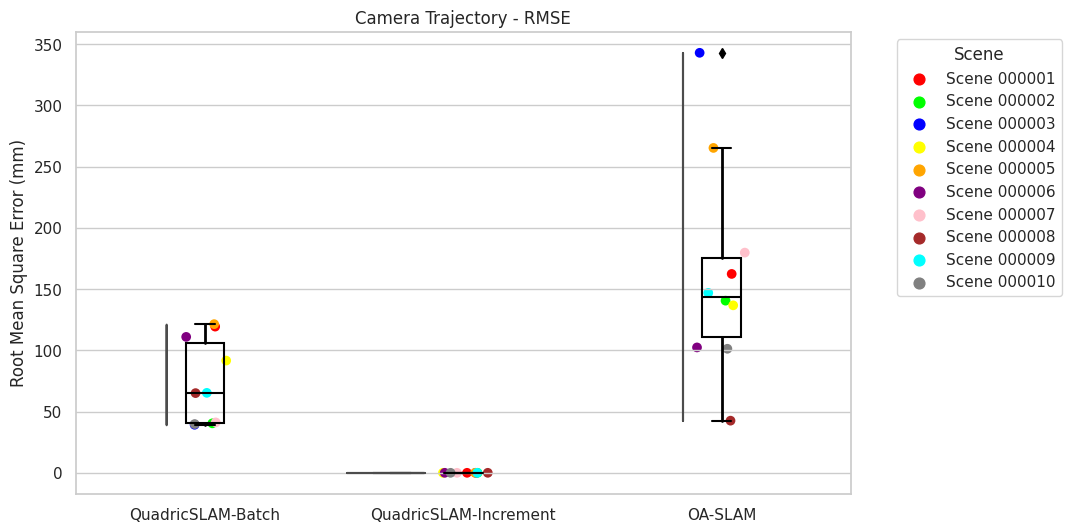

In [6]:
########## All On Same Plot ##########

error_qslam_batch = []
error_qslam_incre = []
error_oaslam = []

# extracting errors as a list
for s in range(num_scenes):
    error_qslam_batch.append(qslam_batch_data[s]['camera_pose']['root_mean_square_error'])
    error_qslam_incre.append(qslam_incre_data[s]['camera_pose']['root_mean_square_error'])
    error_oaslam.append(oaslam_data[s]['camera_pose']['root_mean_square_error'])
    
    
## QuadricSLAM Batch Optimized
data = {'Scene': [f'Scene {s}' for s in scenes],
        'Error': error_qslam_batch,
         'Plot': ['QuadricSLAM-Batch']*num_scenes}
df1 = pd.DataFrame(data)

## QuadricSLAM Incremental Optimized
data = {'Scene': [f'Scene {s}' for s in scenes],
        'Error': error_qslam_incre,
         'Plot': ['QuadricSLAM-Increment']*num_scenes}
df2 = pd.DataFrame(data)

## OA-SLAM
data = {'Scene': [f'Scene {s}' for s in scenes],
        'Error': error_oaslam,
         'Plot': ['OA-SLAM']*num_scenes}

df3 = pd.DataFrame(data)

df = pd.concat([df1, df2, df3], ignore_index=True)

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)

rain_plot(df, "Error", ax)

ax.set_ylabel('Root Mean Square Error (mm)')

plt.title("Camera Trajectory - RMSE")
plt.show()

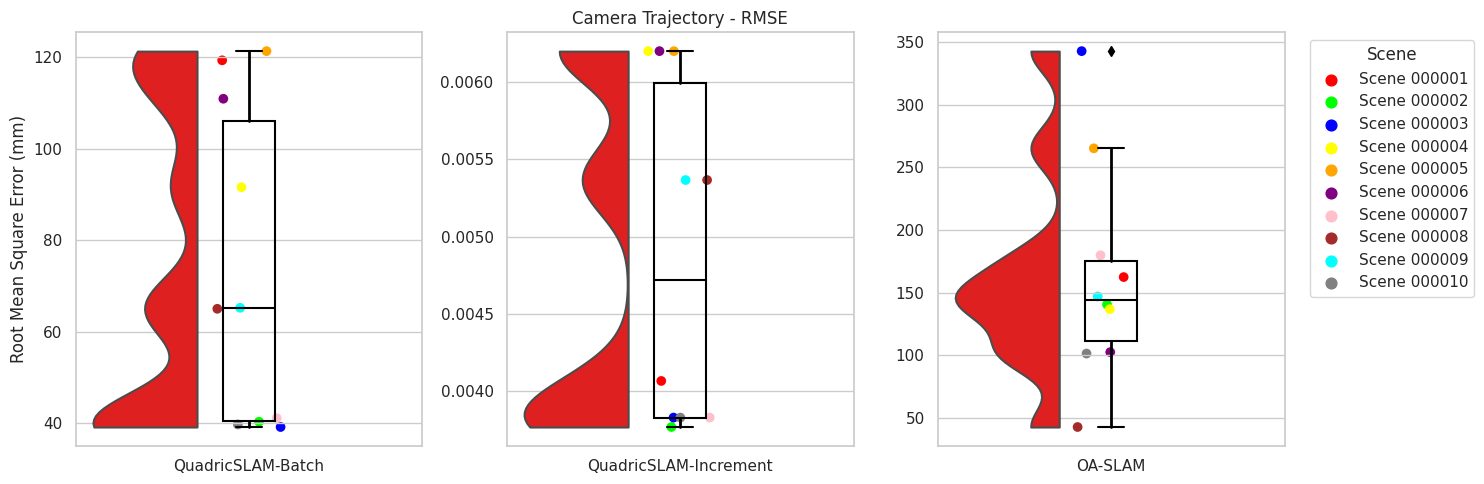

In [7]:
########## All On Three Plots ##########

# Create a figure and manually create subplots
fig = plt.figure(figsize=(15, 5))

# Create three subplots in a single row
ax1 = plt.subplot(1, 3, 1)
rain_plot(df1, "Error", ax1)
ax1.get_legend().remove()
ax1.set_ylabel('Root Mean Square Error (mm)')

ax2 = plt.subplot(1, 3, 2)
rain_plot(df2, "Error", ax2)
ax2.set_title("Camera Trajectory - RMSE")
ax2.get_legend().remove()
ax2.set_ylabel('')

ax3 = plt.subplot(1, 3, 3)
rain_plot(df3, "Error", ax3)
ax3.set_ylabel('')


plt.tight_layout()
plt.show()

### 1. RMSE for Trajectory Deviation - All scenes, 1 line plot for each

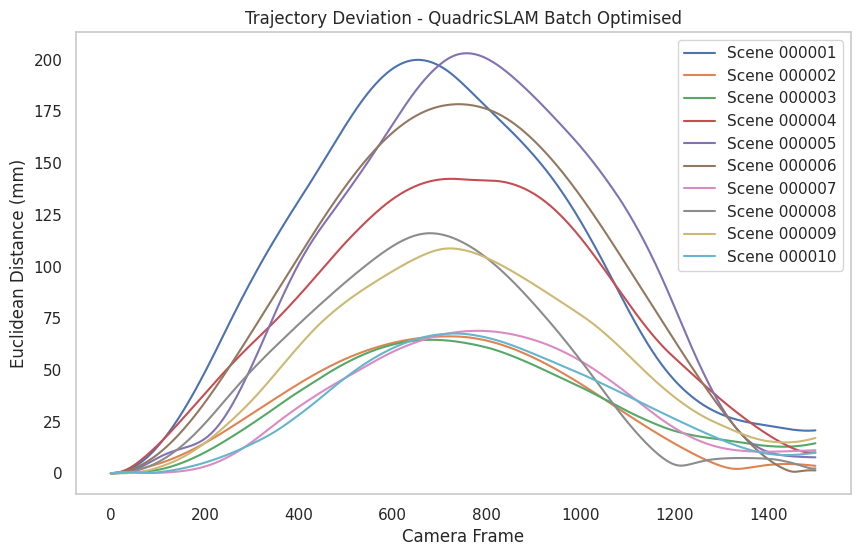

In [8]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)

for s in range(num_scenes):
    ax.plot([i for i in range(len(qslam_batch_data[s]['camera_pose']['euc_error']))],
        qslam_batch_data[s]['camera_pose']['euc_error'], label= 'Scene ' + scenes[s])


ax.set_xlabel('Camera Frame')
ax.set_ylabel('Euclidean Distance (mm)')

plt.title("Trajectory Deviation - QuadricSLAM Batch Optimised")

#plt.legend(loc='upper right')
plt.legend()
plt.grid(False)
plt.show()

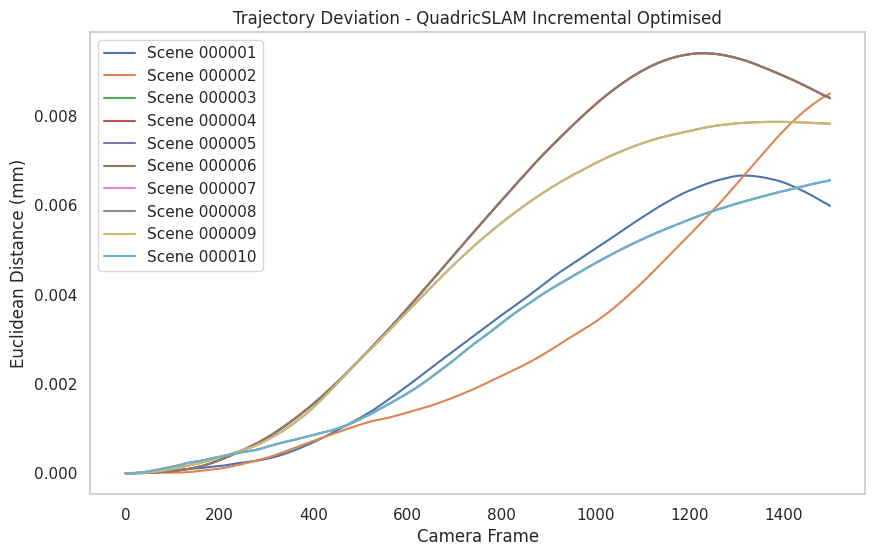

In [9]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)

for s in range(num_scenes):
    ax.plot([i for i in range(len(qslam_incre_data[s]['camera_pose']['euc_error']))],
        qslam_incre_data[s]['camera_pose']['euc_error'], label= 'Scene ' + scenes[s])


ax.set_xlabel('Camera Frame')
ax.set_ylabel('Euclidean Distance (mm)')

plt.title("Trajectory Deviation - QuadricSLAM Incremental Optimised")

plt.legend()
plt.grid(False)
plt.show()

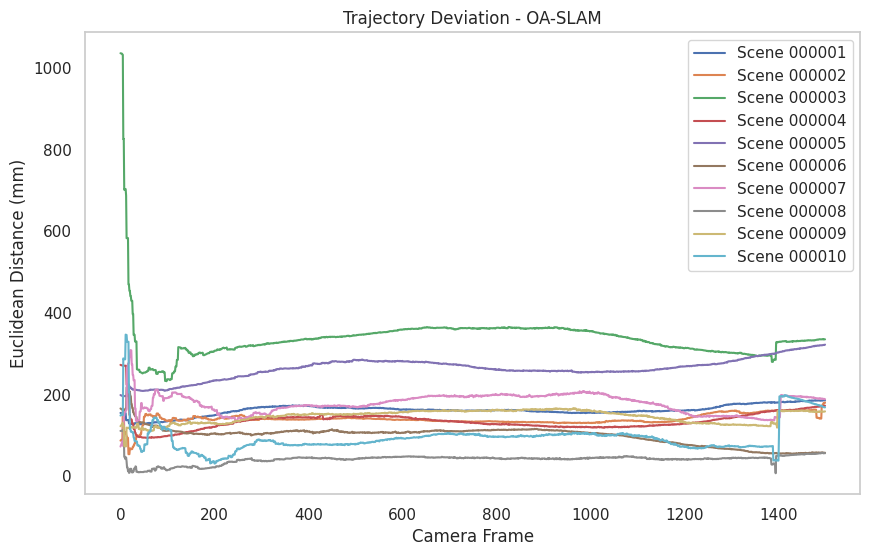

In [10]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)

for s in range(num_scenes):
    ax.plot([i for i in range(len(oaslam_data[s]['camera_pose']['euc_error']))],
        oaslam_data[s]['camera_pose']['euc_error'], label= 'Scene ' + scenes[s])


ax.set_xlabel('Camera Frame')
ax.set_ylabel('Euclidean Distance (mm)')

plt.title("Trajectory Deviation - OA-SLAM")

#plt.legend(loc='upper right')
plt.legend()
plt.grid(False)
plt.show()

### 2. Average Rotation Error for Camera Poses - All scenes, 3 rainfall plots

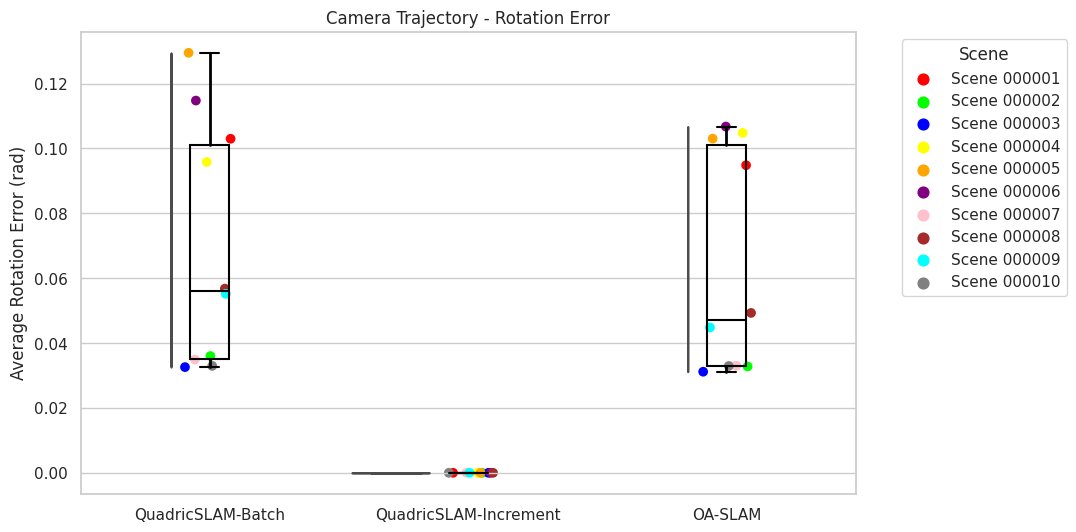

In [11]:
########## All On Same Plot ##########

error_qslam_batch = []
error_qslam_incre = []
error_oaslam = []

# extracting errors as a list
for s in range(num_scenes):
    error_qslam_batch.append(qslam_batch_data[s]['camera_pose']['average_rotation_error'])
    error_qslam_incre.append(qslam_incre_data[s]['camera_pose']['average_rotation_error'])
    error_oaslam.append(oaslam_data[s]['camera_pose']['average_rotation_error'])

## QuadricSLAM Batch Optimized
data = {'Scene': [f'Scene {s}' for s in scenes],
        'Error': error_qslam_batch,
         'Plot': ['QuadricSLAM-Batch']*num_scenes}
df1 = pd.DataFrame(data)

## QuadricSLAM Incremental Optimized
data = {'Scene': [f'Scene {s}' for s in scenes],
        'Error': error_qslam_incre,
         'Plot': ['QuadricSLAM-Increment']*num_scenes}
df2 = pd.DataFrame(data)

## OA-SLAM
data = {'Scene': [f'Scene {s}' for s in scenes],
        'Error': error_oaslam,
         'Plot': ['OA-SLAM']*num_scenes}

df3 = pd.DataFrame(data)

df = pd.concat([df1, df2, df3], ignore_index=True)

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)

rain_plot(df, "Error", ax)

ax.set_ylabel('Average Rotation Error (rad)')

plt.title("Camera Trajectory - Rotation Error")
plt.show()

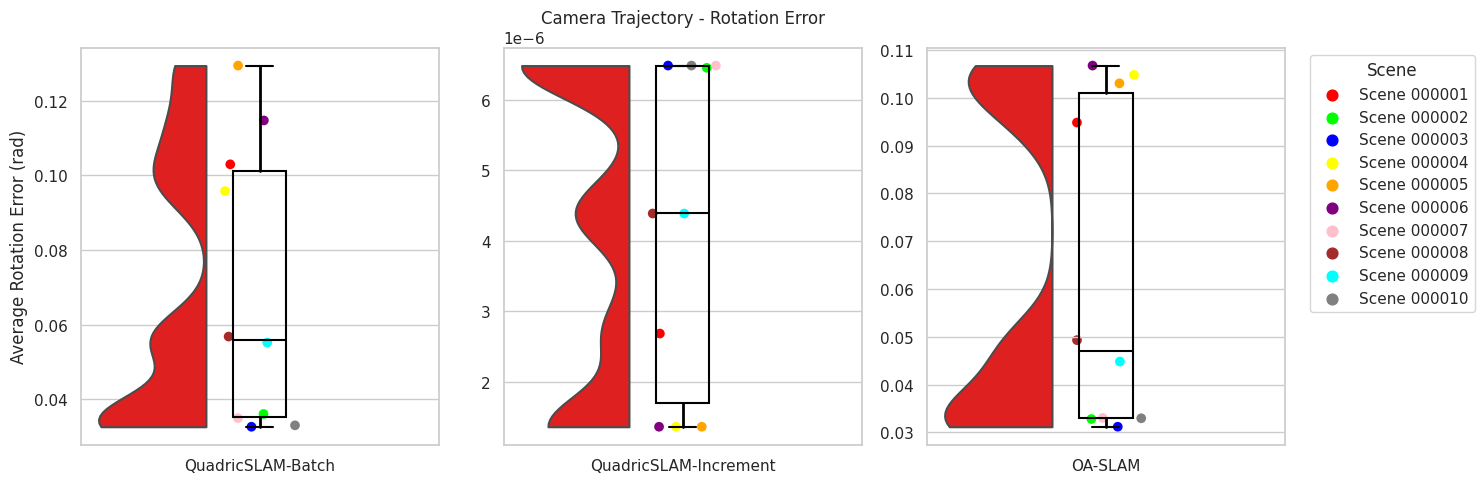

In [12]:
########## All On Three Plots ##########

# Create a figure and manually create subplots
fig = plt.figure(figsize=(15, 5))

# Create three subplots in a single row
ax1 = plt.subplot(1, 3, 1)
rain_plot(df1, "Error", ax1)
ax1.get_legend().remove()
ax1.set_ylabel('Average Rotation Error (rad)')

ax2 = plt.subplot(1, 3, 2)
rain_plot(df2, "Error", ax2)
ax2.set_title("Camera Trajectory - Rotation Error")
ax2.get_legend().remove()
ax2.set_ylabel('')

ax3 = plt.subplot(1, 3, 3)
rain_plot(df3, "Error", ax3)
ax3.set_ylabel('')


plt.tight_layout()
plt.show()

### 2. Average Rotation Error for Camera Poses - All scenes, 1 line plot for each

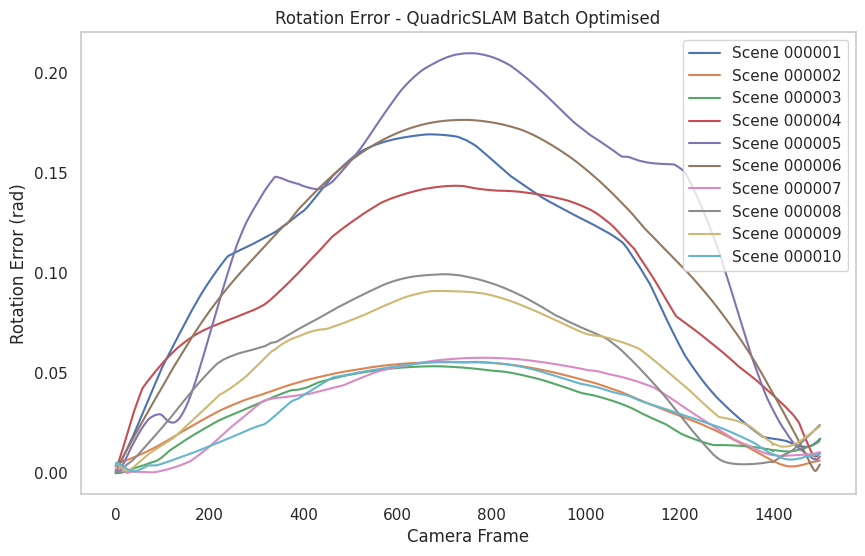

In [13]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)


for s in range(num_scenes):
    ax.plot([i for i in range(len(qslam_batch_data[s]['camera_pose']['rotation_error']))],
        qslam_batch_data[s]['camera_pose']['rotation_error'], label= 'Scene ' + scenes[s])


ax.set_xlabel('Camera Frame')
ax.set_ylabel('Rotation Error (rad)')

plt.title("Rotation Error - QuadricSLAM Batch Optimised")

#plt.legend(loc='upper right')
plt.legend()
plt.grid(False)
plt.show()

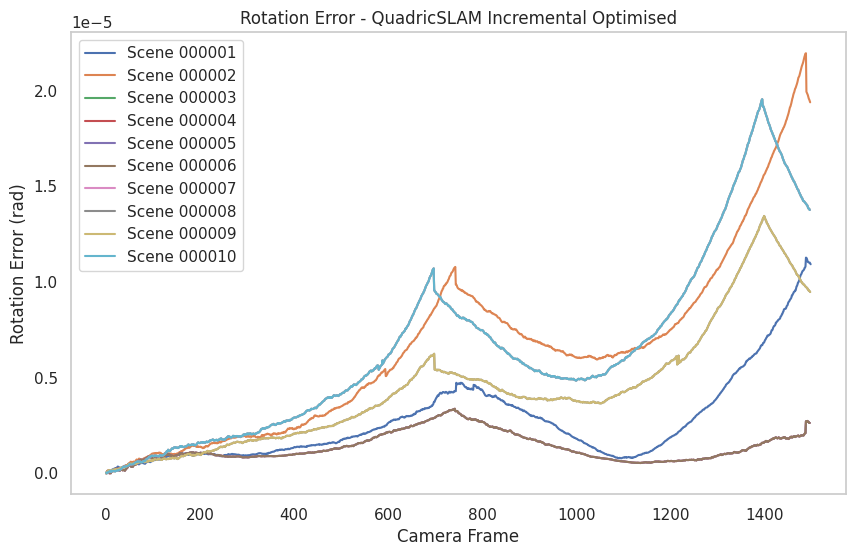

In [14]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)

for s in range(num_scenes):
    ax.plot([i for i in range(len(qslam_incre_data[s]['camera_pose']['rotation_error']))],
        qslam_incre_data[s]['camera_pose']['rotation_error'], label= 'Scene ' + scenes[s])


ax.set_xlabel('Camera Frame')
ax.set_ylabel('Rotation Error (rad)')

plt.title("Rotation Error - QuadricSLAM Incremental Optimised")

plt.legend()
plt.grid(False)
plt.show()

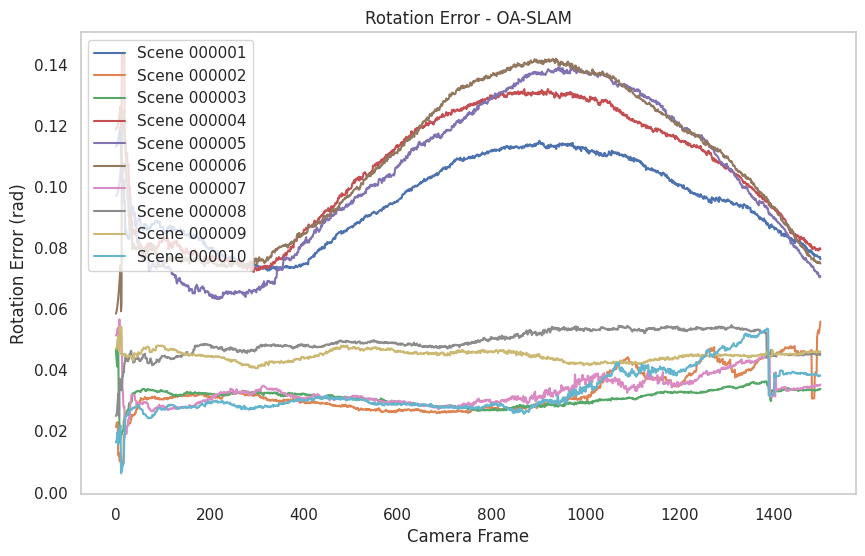

In [15]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)

for s in range(num_scenes):
    ax.plot([i for i in range(len(oaslam_data[s]['camera_pose']['rotation_error']))],
        oaslam_data[s]['camera_pose']['rotation_error'], label= 'Scene ' + scenes[s])


ax.set_xlabel('Camera Frame')
ax.set_ylabel('Rotation Error (rad)')

plt.title("Rotation Error - OA-SLAM")

#plt.legend(loc='upper right')
plt.legend()
plt.grid(False)
plt.show()

### 3. Disparity Measure by Procrustes Analysis - All scenes, 3 rainfall plots

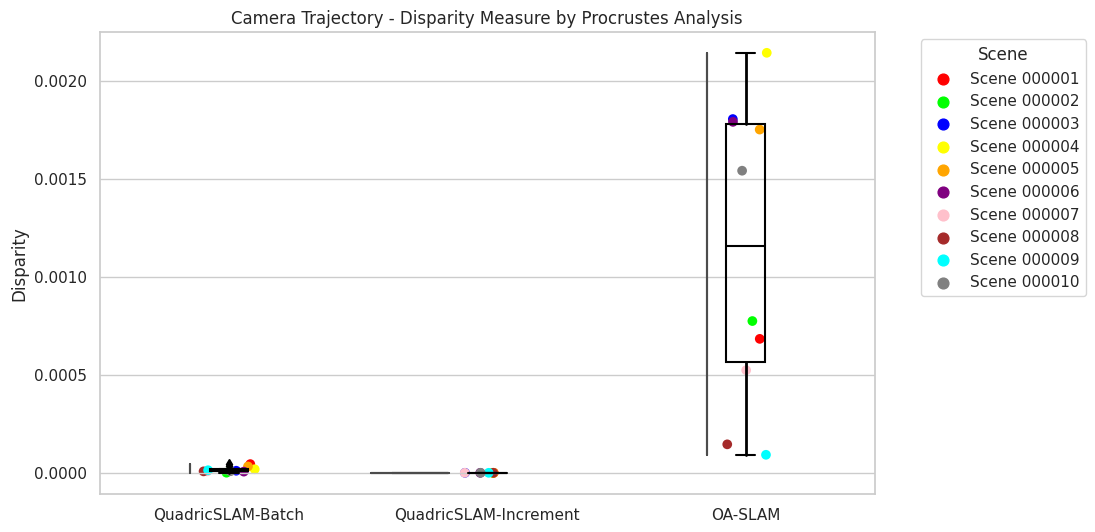

In [16]:
########## All On Same Plot ##########

error_qslam_batch = []
error_qslam_incre = []
error_oaslam = []

# extracting errors as a list
for s in range(num_scenes):
    error_qslam_batch.append(qslam_batch_data[s]['camera_pose']['disparity'])
    error_qslam_incre.append(qslam_incre_data[s]['camera_pose']['disparity'])
    error_oaslam.append(oaslam_data[s]['camera_pose']['disparity'])


## QuadricSLAM Batch Optimized
data = {'Scene': [f'Scene {s}' for s in scenes],
        'Error': error_qslam_batch,
         'Plot': ['QuadricSLAM-Batch']*num_scenes}
df1 = pd.DataFrame(data)

## QuadricSLAM Incremental Optimized
data = {'Scene': [f'Scene {s}' for s in scenes],
        'Error': error_qslam_incre,
         'Plot': ['QuadricSLAM-Increment']*num_scenes}
df2 = pd.DataFrame(data)

## OA-SLAM
data = {'Scene': [f'Scene {s}' for s in scenes],
        'Error': error_oaslam,
         'Plot': ['OA-SLAM']*num_scenes}

df3 = pd.DataFrame(data)

df = pd.concat([df1, df2, df3], ignore_index=True)

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)

rain_plot(df, "Error", ax)

ax.set_ylabel('Disparity')

plt.title("Camera Trajectory - Disparity Measure by Procrustes Analysis")
plt.show()

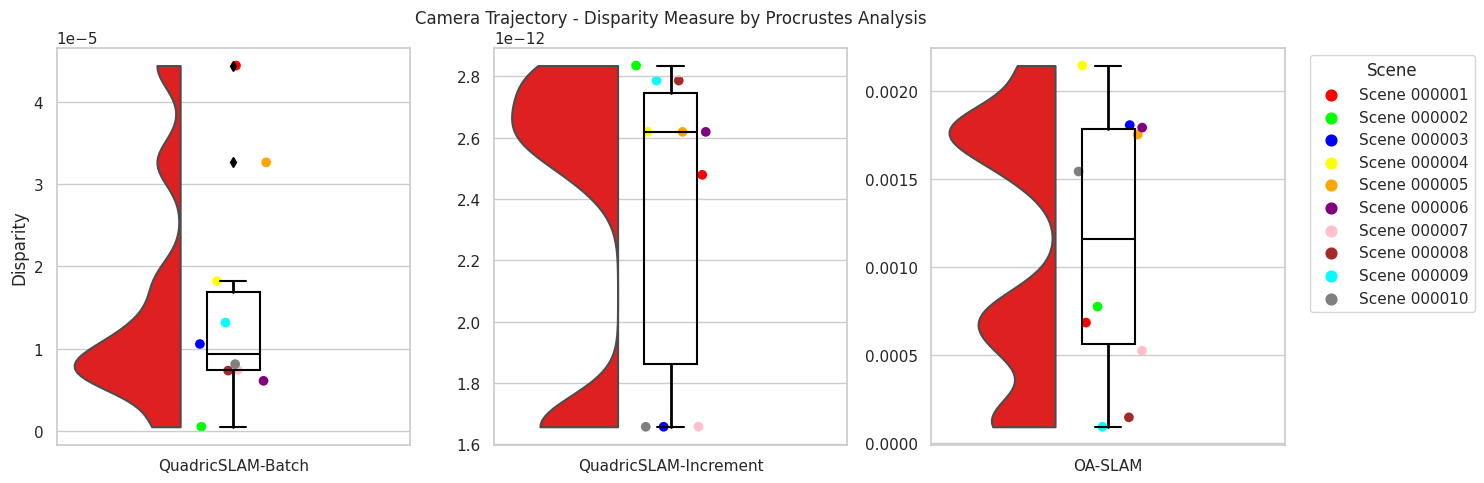

In [17]:
########## All On Three Plots ##########

# Create a figure and manually create subplots
fig = plt.figure(figsize=(15, 5))

# Create three subplots in a single row
ax1 = plt.subplot(1, 3, 1)
rain_plot(df1, "Error", ax1)
ax1.get_legend().remove()
ax1.set_ylabel('Disparity')

ax2 = plt.subplot(1, 3, 2)
rain_plot(df2, "Error", ax2)
ax2.set_title("Camera Trajectory - Disparity Measure by Procrustes Analysis")
ax2.get_legend().remove()
ax2.set_ylabel('')

ax3 = plt.subplot(1, 3, 3)
rain_plot(df3, "Error", ax3)
ax3.set_ylabel('')


plt.tight_layout()
plt.show()

### 4. Fréchet Distance - All scenes, 3 rainfall plots

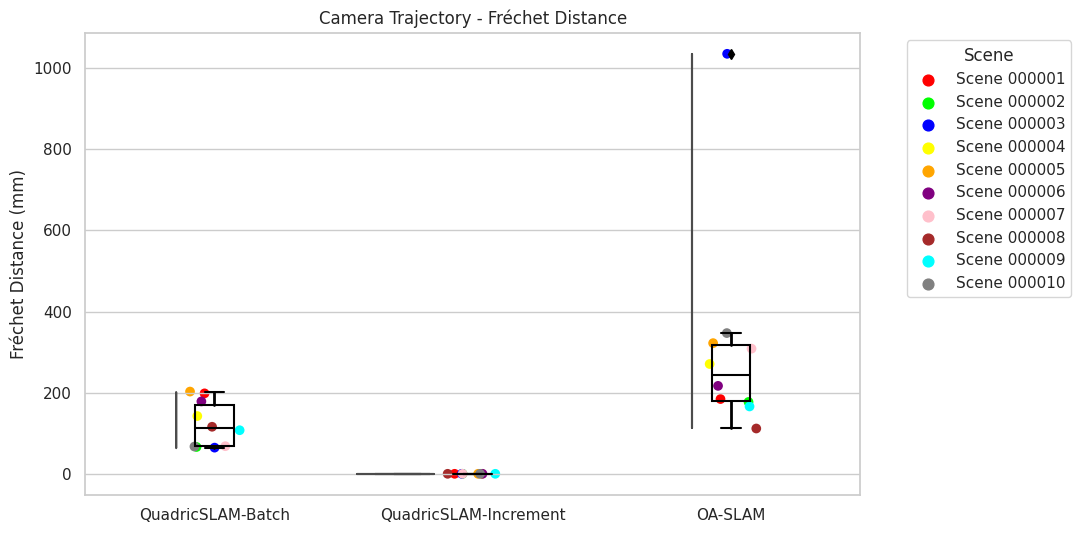

In [18]:
########## All On Same Plot ##########

error_qslam_batch = []
error_qslam_incre = []
error_oaslam = []

# extracting errors as a list
for s in range(num_scenes):
    error_qslam_batch.append(qslam_batch_data[s]['camera_pose']['frechet_distance'])
    error_qslam_incre.append(qslam_incre_data[s]['camera_pose']['frechet_distance'])
    error_oaslam.append(oaslam_data[s]['camera_pose']['frechet_distance'])


## QuadricSLAM Batch Optimized
data = {'Scene': [f'Scene {s}' for s in scenes],
        'Error': error_qslam_batch,
         'Plot': ['QuadricSLAM-Batch']*num_scenes}
df1 = pd.DataFrame(data)

## QuadricSLAM Incremental Optimized
data = {'Scene': [f'Scene {s}' for s in scenes],
        'Error': error_qslam_incre,
         'Plot': ['QuadricSLAM-Increment']*num_scenes}
df2 = pd.DataFrame(data)

## OA-SLAM
data = {'Scene': [f'Scene {s}' for s in scenes],
        'Error': error_oaslam,
         'Plot': ['OA-SLAM']*num_scenes}

df3 = pd.DataFrame(data)

df = pd.concat([df1, df2, df3], ignore_index=True)

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)

rain_plot(df, "Error", ax)

ax.set_ylabel('Fréchet Distance (mm)')

plt.title("Camera Trajectory - Fréchet Distance")
plt.show()

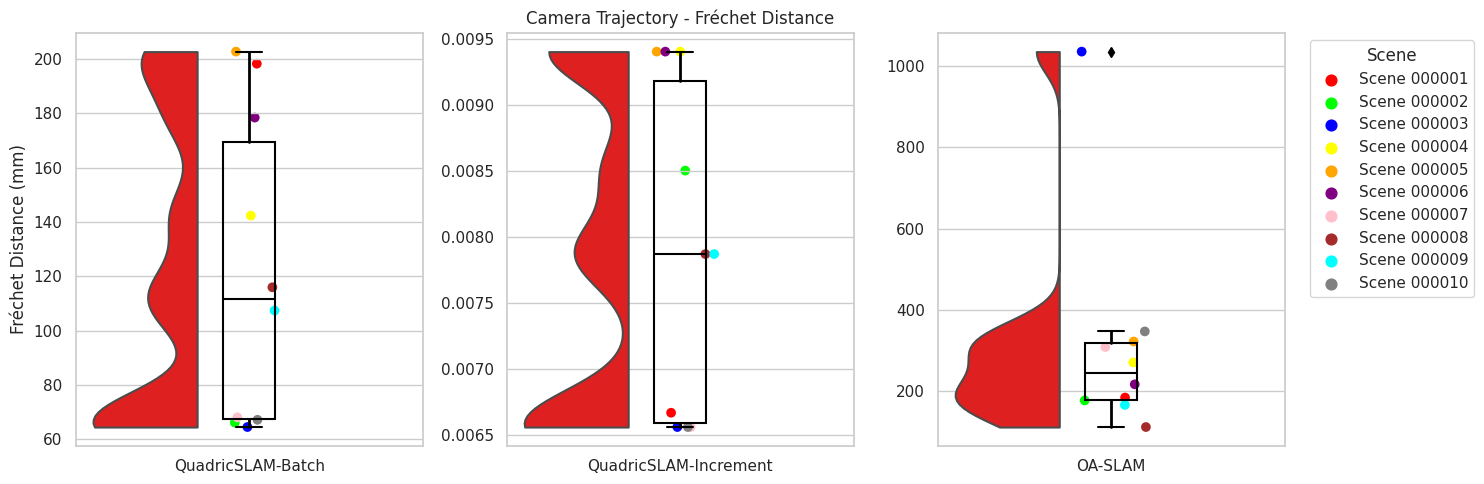

In [19]:
########## All On Three Plots ##########

# Create a figure and manually create subplots
fig = plt.figure(figsize=(15, 5))

# Create three subplots in a single row
ax1 = plt.subplot(1, 3, 1)
rain_plot(df1, "Error", ax1)
ax1.get_legend().remove()
ax1.set_ylabel('Fréchet Distance (mm)')

ax2 = plt.subplot(1, 3, 2)
rain_plot(df2, "Error", ax2)
ax2.set_title("Camera Trajectory - Fréchet Distance")
ax2.get_legend().remove()
ax2.set_ylabel('')

ax3 = plt.subplot(1, 3, 3)
rain_plot(df3, "Error", ax3)
ax3.set_ylabel('')


plt.tight_layout()
plt.show()

### 5. Chamfer Distance - All scenes, 3 rainfall plots

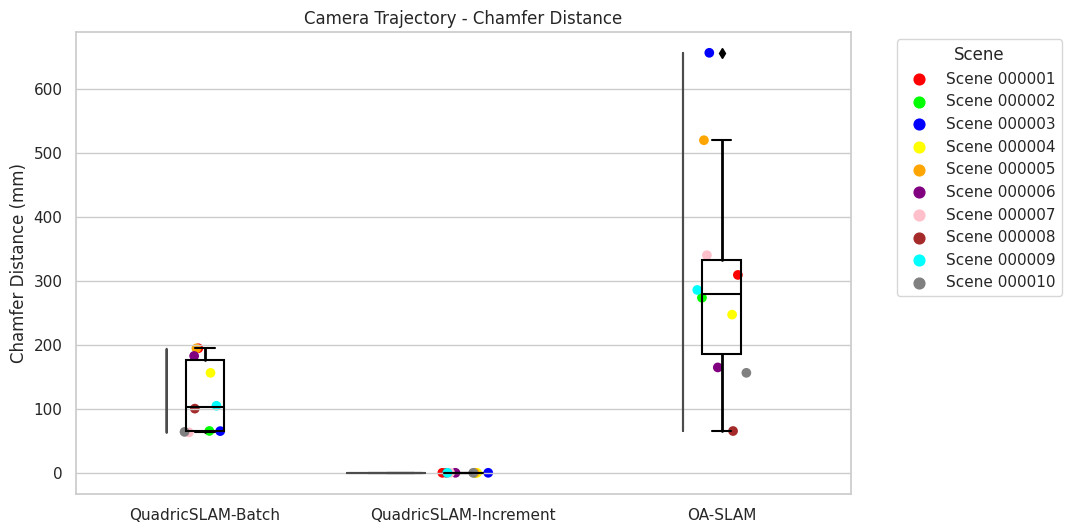

In [20]:
########## All On Same Plot ##########

error_qslam_batch = []
error_qslam_incre = []
error_oaslam = []

# extracting errors as a list
for s in range(num_scenes):
    error_qslam_batch.append(qslam_batch_data[s]['camera_pose']['chamfer_distance'])
    error_qslam_incre.append(qslam_incre_data[s]['camera_pose']['chamfer_distance'])
    error_oaslam.append(oaslam_data[s]['camera_pose']['chamfer_distance'])


## QuadricSLAM Batch Optimized
data = {'Scene': [f'Scene {s}' for s in scenes],
        'Error': error_qslam_batch,
         'Plot': ['QuadricSLAM-Batch']*num_scenes}
df1 = pd.DataFrame(data)

## QuadricSLAM Incremental Optimized
data = {'Scene': [f'Scene {s}' for s in scenes],
        'Error': error_qslam_incre,
         'Plot': ['QuadricSLAM-Increment']*num_scenes}
df2 = pd.DataFrame(data)

## OA-SLAM
data = {'Scene': [f'Scene {s}' for s in scenes],
        'Error': error_oaslam,
         'Plot': ['OA-SLAM']*num_scenes}

df3 = pd.DataFrame(data)

df = pd.concat([df1, df2, df3], ignore_index=True)

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)

rain_plot(df, "Error", ax)

ax.set_ylabel('Chamfer Distance (mm)')

plt.title("Camera Trajectory - Chamfer Distance")
plt.show()

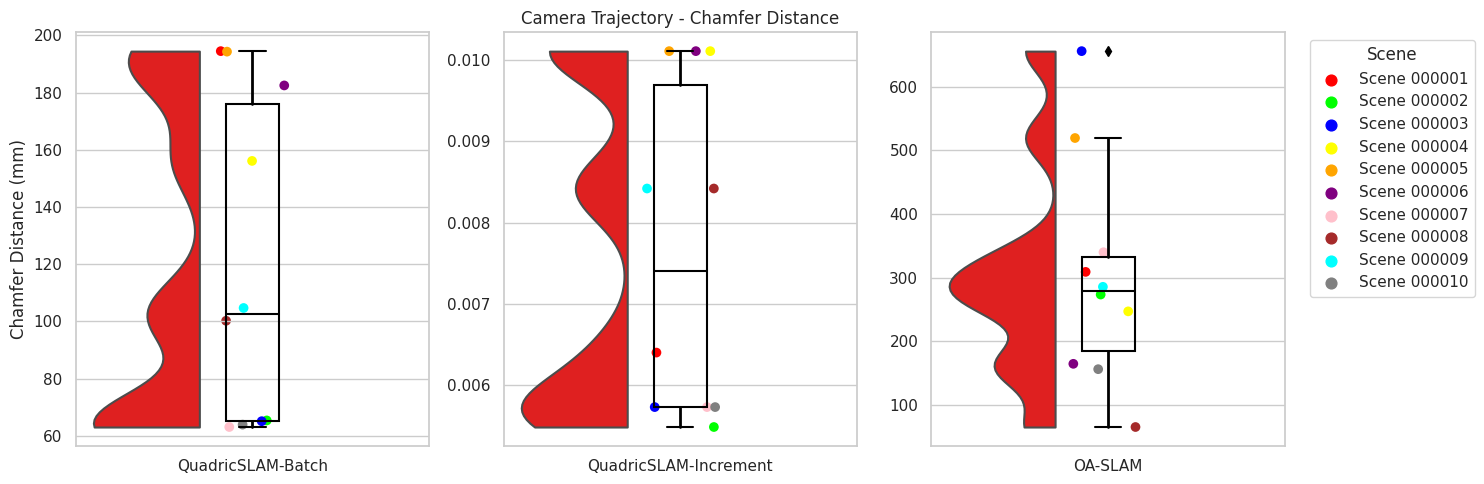

In [21]:
########## All On Three Plots ##########

# Create a figure and manually create subplots
fig = plt.figure(figsize=(15, 5))

# Create three subplots in a single row
ax1 = plt.subplot(1, 3, 1)
rain_plot(df1, "Error", ax1)
ax1.get_legend().remove()
ax1.set_ylabel('Chamfer Distance (mm)')

ax2 = plt.subplot(1, 3, 2)
rain_plot(df2, "Error", ax2)
ax2.set_title("Camera Trajectory - Chamfer Distance")
ax2.get_legend().remove()
ax2.set_ylabel('')

ax3 = plt.subplot(1, 3, 3)
rain_plot(df3, "Error", ax3)
ax3.set_ylabel('')


plt.tight_layout()
plt.show()

## OBJECT

### 1. Average Centroid Error - All scenes, 3 rainfall plots

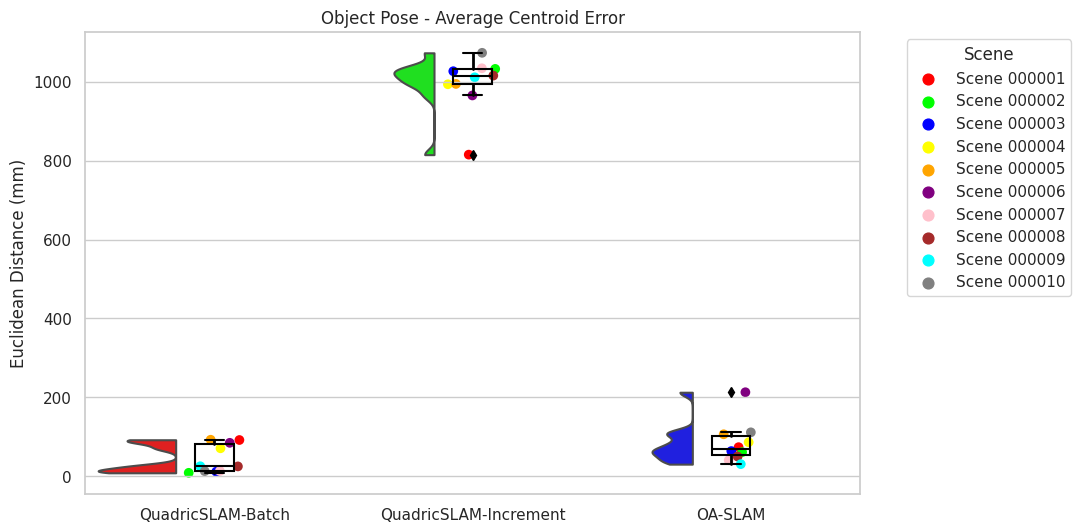

In [22]:
########## All On Same Plot ##########

error_qslam_batch = []
error_qslam_incre = []
error_oaslam = []

# extracting errors as a list
for s in range(num_scenes):
    error_qslam_batch.append(qslam_batch_data[s]['object_pose']['average_centroid_error'])
    error_qslam_incre.append(qslam_incre_data[s]['object_pose']['average_centroid_error'])
    error_oaslam.append(oaslam_data[s]['object_pose']['average_centroid_error'])



## QuadricSLAM Batch Optimized
data = {'Scene': [f'Scene {s}' for s in scenes],
        'Error': error_qslam_batch,
         'Plot': ['QuadricSLAM-Batch']*num_scenes}
df1 = pd.DataFrame(data)

## QuadricSLAM Incremental Optimized
data = {'Scene': [f'Scene {s}' for s in scenes],
        'Error': error_qslam_incre,
         'Plot': ['QuadricSLAM-Increment']*num_scenes}
df2 = pd.DataFrame(data)

## OA-SLAM
data = {'Scene': [f'Scene {s}' for s in scenes],
        'Error': error_oaslam,
         'Plot': ['OA-SLAM']*num_scenes}

df3 = pd.DataFrame(data)

df = pd.concat([df1, df2, df3], ignore_index=True)

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)

rain_plot(df, "Error", ax)

ax.set_ylabel('Euclidean Distance (mm)')

plt.title("Object Pose - Average Centroid Error")
plt.show()

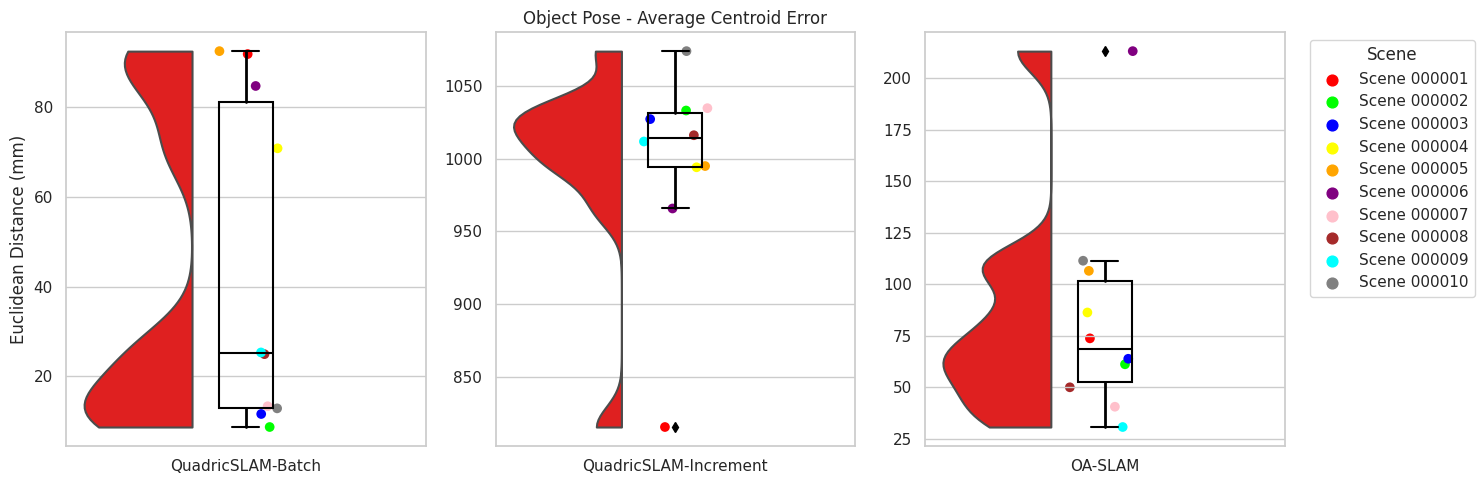

In [23]:
########## All On Three Plots ##########

# Create a figure and manually create subplots
fig = plt.figure(figsize=(15, 5))

# Create three subplots in a single row
ax1 = plt.subplot(1, 3, 1)
rain_plot(df1, "Error", ax1)
ax1.get_legend().remove()
ax1.set_ylabel('Euclidean Distance (mm)')

ax2 = plt.subplot(1, 3, 2)
rain_plot(df2, "Error", ax2)
ax2.set_title("Object Pose - Average Centroid Error")
ax2.get_legend().remove()
ax2.set_ylabel('')

ax3 = plt.subplot(1, 3, 3)
rain_plot(df3, "Error", ax3)
ax3.set_ylabel('')


plt.tight_layout()
plt.show()

### 2. Average Rotation Error - All scenes, 3 rainfall plots

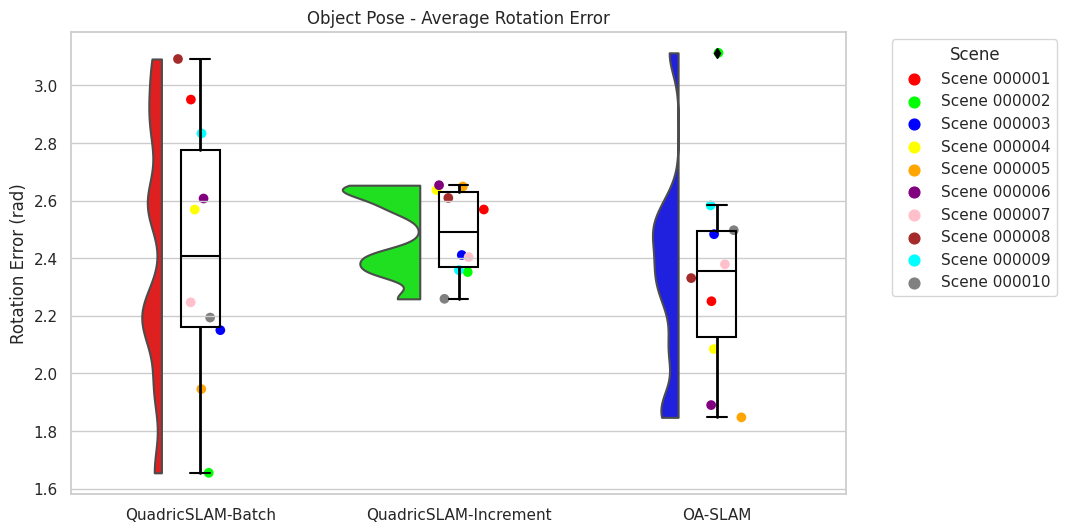

In [24]:
########## All On Same Plot ##########

error_qslam_batch = []
error_qslam_incre = []
error_oaslam = []

# extracting errors as a list
for s in range(num_scenes):
    error_qslam_batch.append(qslam_batch_data[s]['object_pose']['average_rotation_error'])
    error_qslam_incre.append(qslam_incre_data[s]['object_pose']['average_rotation_error'])
    error_oaslam.append(oaslam_data[s]['object_pose']['average_rotation_error'])


## QuadricSLAM Batch Optimized
data = {'Scene': [f'Scene {s}' for s in scenes],
        'Error': error_qslam_batch,
         'Plot': ['QuadricSLAM-Batch']*num_scenes}
df1 = pd.DataFrame(data)

## QuadricSLAM Incremental Optimized
data = {'Scene': [f'Scene {s}' for s in scenes],
        'Error': error_qslam_incre,
         'Plot': ['QuadricSLAM-Increment']*num_scenes}
df2 = pd.DataFrame(data)

## OA-SLAM
data = {'Scene': [f'Scene {s}' for s in scenes],
        'Error': error_oaslam,
         'Plot': ['OA-SLAM']*num_scenes}

df3 = pd.DataFrame(data)

df = pd.concat([df1, df2, df3], ignore_index=True)

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)

rain_plot(df, "Error", ax)

ax.set_ylabel('Rotation Error (rad)')

plt.title("Object Pose - Average Rotation Error")
plt.show()

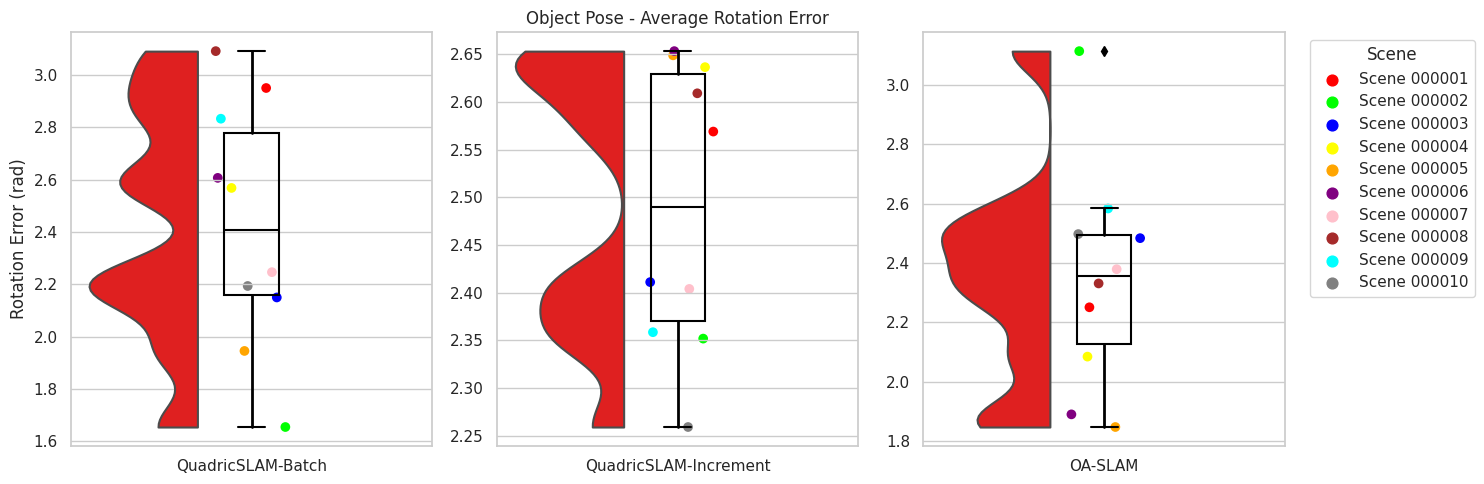

In [25]:
########## All On Three Plots ##########

# Create a figure and manually create subplots
fig = plt.figure(figsize=(15, 5))

# Create three subplots in a single row
ax1 = plt.subplot(1, 3, 1)
rain_plot(df1, "Error", ax1)
ax1.get_legend().remove()
ax1.set_ylabel('Rotation Error (rad)')

ax2 = plt.subplot(1, 3, 2)
rain_plot(df2, "Error", ax2)
ax2.set_title("Object Pose - Average Rotation Error")
ax2.get_legend().remove()
ax2.set_ylabel('')

ax3 = plt.subplot(1, 3, 3)
rain_plot(df3, "Error", ax3)
ax3.set_ylabel('')


plt.tight_layout()
plt.show()

### 3. Percentage of Intersection Volume - All scenes, 3 rainfall plots

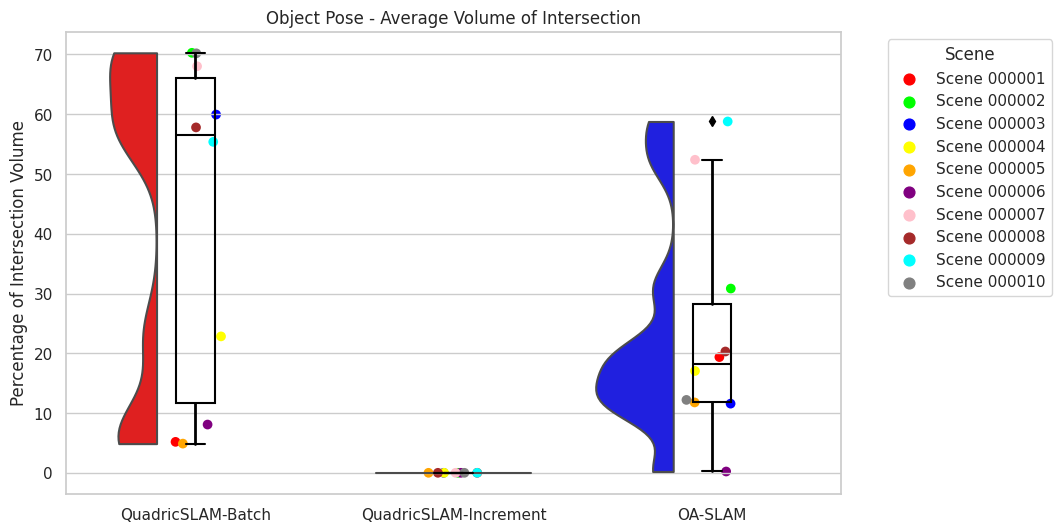

In [26]:
########## All On Same Plot ##########

error_qslam_batch = []
error_qslam_incre = []
error_oaslam = []

# extracting errors as a list
for s in range(num_scenes):
    error_qslam_batch.append(qslam_batch_data[s]['object_pose']['average_volume_of_intersection'])
    error_qslam_incre.append(qslam_incre_data[s]['object_pose']['average_volume_of_intersection'])
    error_oaslam.append(oaslam_data[s]['object_pose']['average_volume_of_intersection'])


## QuadricSLAM Batch Optimized
data = {'Scene': [f'Scene {s}' for s in scenes],
        'Error': error_qslam_batch,
         'Plot': ['QuadricSLAM-Batch']*num_scenes}
df1 = pd.DataFrame(data)

## QuadricSLAM Incremental Optimized
data = {'Scene': [f'Scene {s}' for s in scenes],
        'Error': error_qslam_incre,
         'Plot': ['QuadricSLAM-Increment']*num_scenes}
df2 = pd.DataFrame(data)

## OA-SLAM
data = {'Scene': [f'Scene {s}' for s in scenes],
        'Error': error_oaslam,
         'Plot': ['OA-SLAM']*num_scenes}

df3 = pd.DataFrame(data)

df = pd.concat([df1, df2, df3], ignore_index=True)

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)

rain_plot(df, "Error", ax)

ax.set_ylabel('Percentage of Intersection Volume')

plt.title("Object Pose - Average Volume of Intersection")
plt.show()

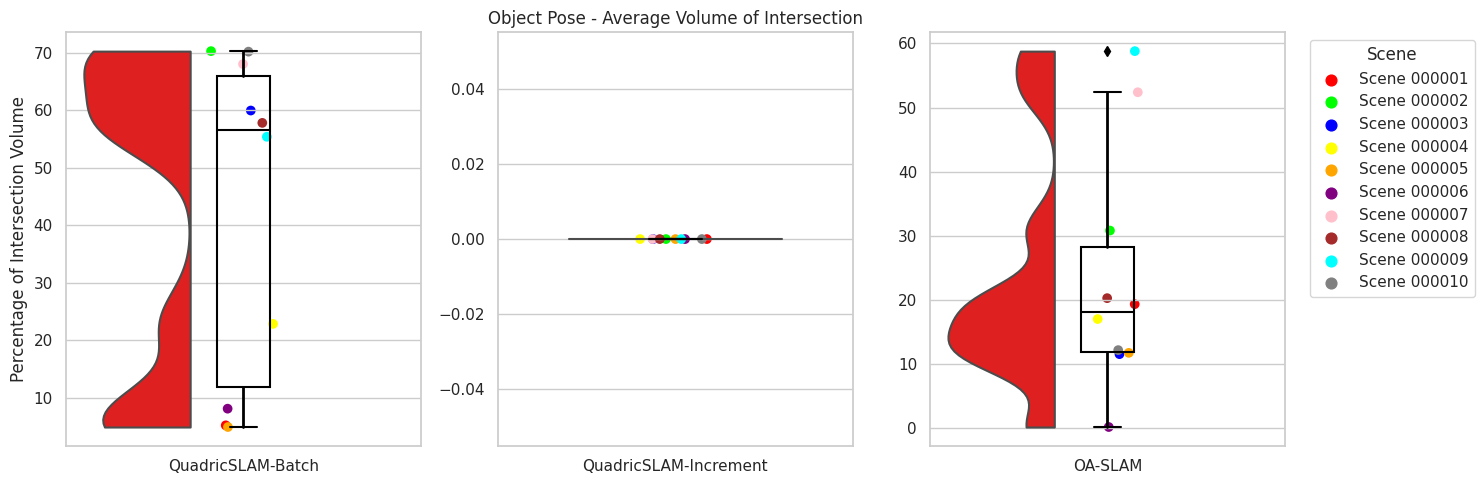

In [27]:
########## All On Three Plots ##########

# Create a figure and manually create subplots
fig = plt.figure(figsize=(15, 5))

# Create three subplots in a single row
ax1 = plt.subplot(1, 3, 1)
rain_plot(df1, "Error", ax1)
ax1.get_legend().remove()
ax1.set_ylabel('Percentage of Intersection Volume')

ax2 = plt.subplot(1, 3, 2)
rain_plot(df2, "Error", ax2)
ax2.set_title("Object Pose - Average Volume of Intersection")
ax2.get_legend().remove()
ax2.set_ylabel('')

ax3 = plt.subplot(1, 3, 3)
rain_plot(df3, "Error", ax3)
ax3.set_ylabel('')


plt.tight_layout()
plt.show()

### 4. Percentage of Aligned Intersection Volume - All scenes, 3 rainfall plots

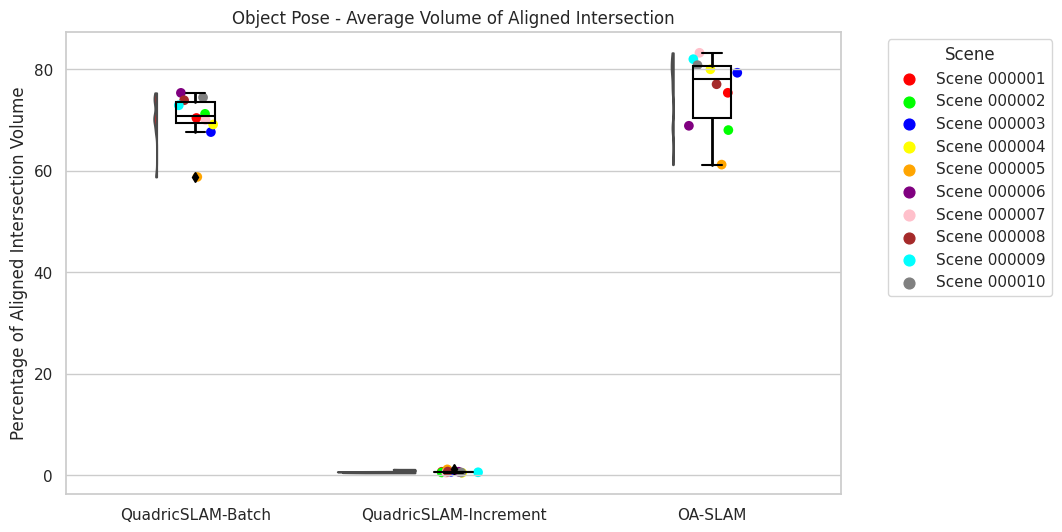

In [28]:
########## All On Same Plot ##########

error_qslam_batch = []
error_qslam_incre = []
error_oaslam = []

# extracting errors as a list
for s in range(num_scenes):
    error_qslam_batch.append(qslam_batch_data[s]['object_pose']['average_volume_of_intersection_aligned'])
    error_qslam_incre.append(qslam_incre_data[s]['object_pose']['average_volume_of_intersection_aligned'])
    error_oaslam.append(oaslam_data[s]['object_pose']['average_volume_of_intersection_aligned'])


## QuadricSLAM Batch Optimized
data = {'Scene': [f'Scene {s}' for s in scenes],
        'Error': error_qslam_batch,
         'Plot': ['QuadricSLAM-Batch']*num_scenes}
df1 = pd.DataFrame(data)

## QuadricSLAM Incremental Optimized
data = {'Scene': [f'Scene {s}' for s in scenes],
        'Error': error_qslam_incre,
         'Plot': ['QuadricSLAM-Increment']*num_scenes}
df2 = pd.DataFrame(data)

## OA-SLAM
data = {'Scene': [f'Scene {s}' for s in scenes],
        'Error': error_oaslam,
         'Plot': ['OA-SLAM']*num_scenes}

df3 = pd.DataFrame(data)

df = pd.concat([df1, df2, df3], ignore_index=True)

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)

rain_plot(df, "Error", ax)

ax.set_ylabel('Percentage of Aligned Intersection Volume')

plt.title("Object Pose - Average Volume of Aligned Intersection")
plt.show()

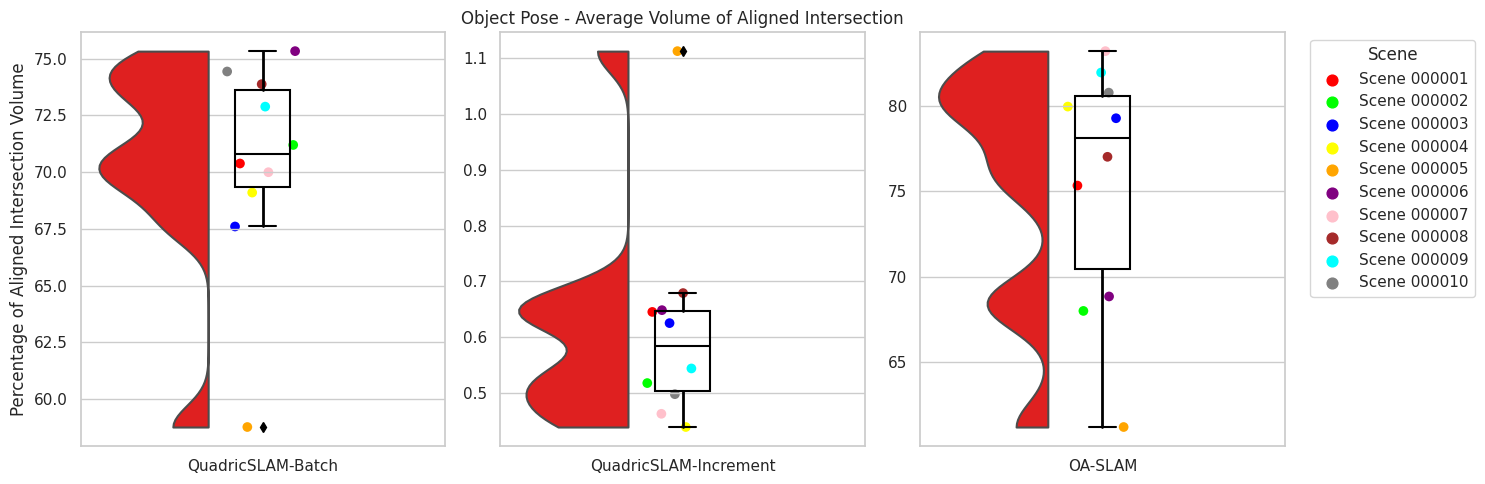

In [29]:
########## All On Three Plots ##########

# Create a figure and manually create subplots
fig = plt.figure(figsize=(15, 5))

# Create three subplots in a single row
ax1 = plt.subplot(1, 3, 1)
rain_plot(df1, "Error", ax1)
ax1.get_legend().remove()
ax1.set_ylabel('Percentage of Aligned Intersection Volume')

ax2 = plt.subplot(1, 3, 2)
rain_plot(df2, "Error", ax2)
ax2.set_title("Object Pose - Average Volume of Aligned Intersection")
ax2.get_legend().remove()
ax2.set_ylabel('')

ax3 = plt.subplot(1, 3, 3)
rain_plot(df3, "Error", ax3)
ax3.set_ylabel('')


plt.tight_layout()
plt.show()